# Inteligencia Artificial
# Clase 10 - Callbacks y Sklearn Wrapper

## Callbacks

En esta notebook, exploraremos algunos [*callbacks* de Keras](https://keras.io/callbacks/) que resultan de gran utilidad al momento de entrenar una red neuronal, en particular:

- `EarlyStopping`, una técnica de regularización que interrumpe el aprendizaje de manera temprana si comienza a detectarse *overfitting*
- `ReduceLROnPlateau`, se encarga de reducir la *learning rate* cuando una determinada métrica de monitoreo deja de mejorar
- `ModelCheckpoint`, nos permite ir guardando los valores de los parámetros aprendidos por la red *epoch* tras *epoch*

Utilizaremos el dataset [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), que consiste en un conjunto de imágenes de ropa en escala de grises de 28x28 píxels, cada una asociada con una etiqueta de entre 10 clases posibles. Al igual que el MNIST, este dataset viene precargado con Keras y se estructura en un train set de 60.000 ejemplos y un test set de 10.000 ejemplos.

<img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" width=700 />
<center><i>Algunos ejemplos del dataset Fashion MNIST</i></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Cargamos el dataset
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# Evaluamos las shapes de train y test
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
# Especificamos los nombres de cada clase
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

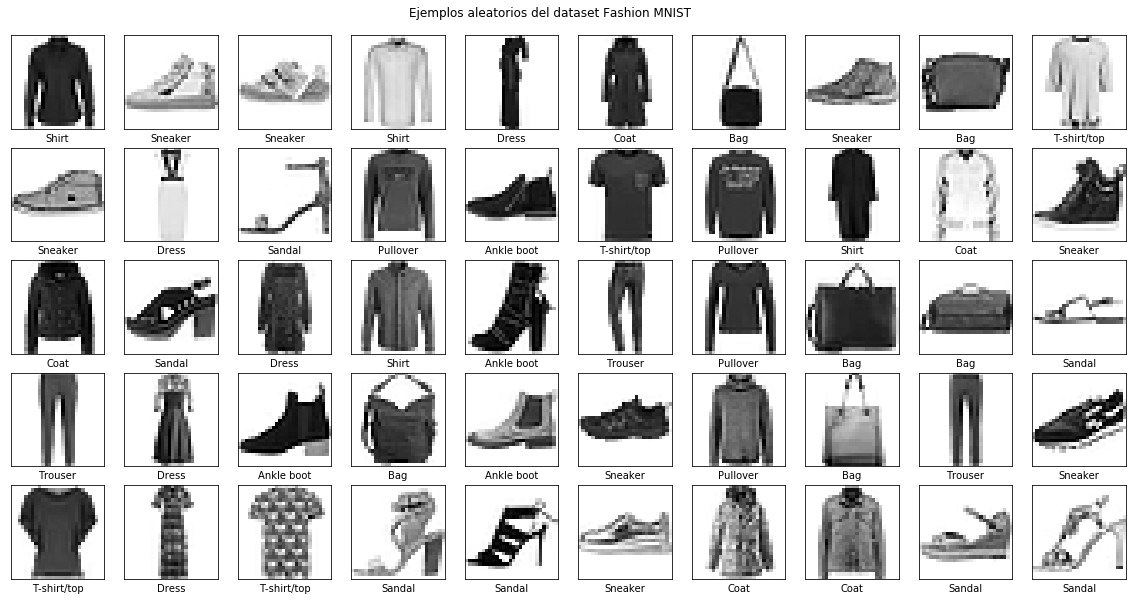

In [5]:
# Visualizamos algunas de las imágenes contenidas en el dataset
plt.figure(figsize=(20, 10))
plt.suptitle('Ejemplos aleatorios del dataset Fashion MNIST', y=0.92)

for i, j in enumerate(np.random.choice(x_train.shape[0], 50)):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[j], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[j]])

plt.show()

Codificamos categóricamente las *labels*.

In [6]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

Normalizamos las *features*.

In [7]:
x_train = x_train / 255
x_test = x_test / 255

Definimos una arquitectura de red con una sola capa oculta de 512 neuronas, activadas con `relu`, con una *dropout rate* del 50%. En la capa de salida incorporamos 10 neuronas, activadas con `softmax`.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout 

In [9]:
# Definimos el modelo
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
# Inspeccionamos el summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


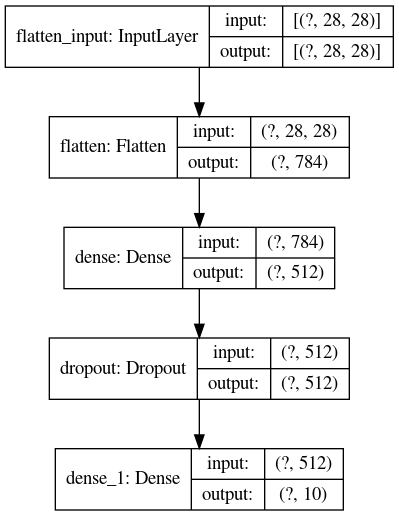

In [11]:
# Podemos generar una imagen de nuestro modelo con el método plot_model()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [12]:
# Compilamos el modelo
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## `EarlyStopping`

Cuando estudiamos diferentes técnicas de regularización, presentamos `EarlyStopping`, que se encarga de detener el entrenamiento de un modelo cuando comienza a aumentar el error de validación. Recordemos que para trabajar con `EarlyStopping`, y con cualquier *callback* en general, debemos importar la clase en cuestión del módulo de `callbacks` de Keras y crear una instancia en que especificamos distintos argumentos.

`EarlyStopping` recibe los siguientes argumentos:

- `monitor`: la métrica que queremos monitorear durante el aprendizaje
- `min_delta`: cuál es la variación mínima entre *epochs* de la métrica monitoreada que definimos como una mejora (un cambio de la métrica inferior a `min_delta` no será considerado como un incremento de *performance*)
- `patience`: número de *epochs* que esperamos una mejora en la métrica monitoreada (si transcurren más *epochs* que esta cantidad definida sin mejoras, el entrenamiento se interrumpe)
- `verbose`: regula la verbosidad del *callback*
- `mode`: puede ser alguno de `{auto, min, max}`, esto es, si se quiere minimizar o maximizar el valor de `monitor` (`auto` infiere este comportamiento por sí mismo)
- `baseline`: el entrenamiento se detiene si la cantidad no supera este valor (por default, infinito)
- `restore_best_weights`: se puede setear en `True` para recuperar los valores de los parámetros propios del *epoch* con el mejor valor de la métrica monitoreada (si se setea en `False`, el modelo conservará los paramétros de la última iteración)

In [13]:
# Importamos la clase EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

# Instanciamos nuestro objeto early_stopping y definimos una lista de callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True, verbose=1)
callbacks_list = [early_stopping]

In [14]:
# Entrenamos
history = model.fit(x_train, y_train, validation_split=10000/x_train.shape[0],
                    batch_size=32, epochs=20,
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 230us/sample - loss: 0.5970 - accuracy: 0.7904 - val_loss: 0.5191 - val_accuracy: 0.8267
Epoch 2/20
50000/50000 [==============================] - 11s 221us/sample - loss: 0.4807 - accuracy: 0.8356 - val_loss: 0.4373 - val_accuracy: 0.8518
Epoch 3/20
50000/50000 [==============================] - 10s 209us/sample - loss: 0.4542 - accuracy: 0.8493 - val_loss: 0.4162 - val_accuracy: 0.8676
Epoch 4/20
50000/50000 [==============================] - 14s 271us/sample - loss: 0.4559 - accuracy: 0.8522 - val_loss: 0.4123 - val_accuracy: 0.8720
Epoch 5/20
50000/50000 [==============================] - 15s 293us/sample - loss: 0.4485 - accuracy: 0.8578 - val_loss: 0.4254 - val_accuracy: 0.8690
Epoch 6/20
50000/50000 [==============================] - 13s 263us/sample - loss: 0.4482 - accuracy: 0.8608 - val_loss: 0.4227 - val_accuracy: 0.8697
Epoch 7/20
50000/50000 [====================

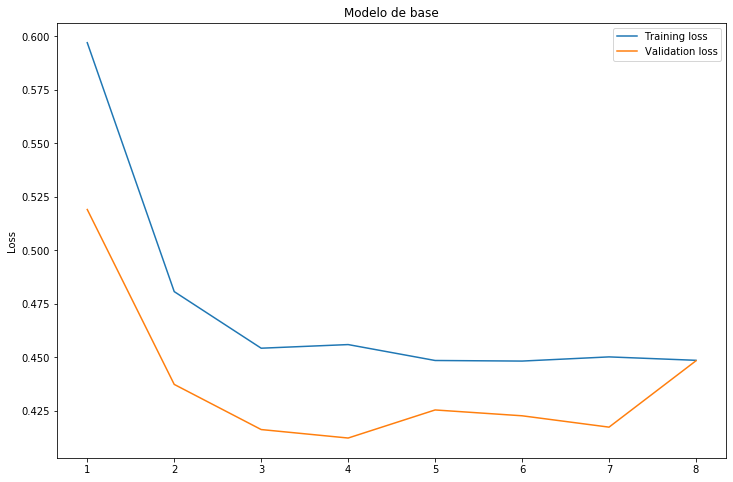

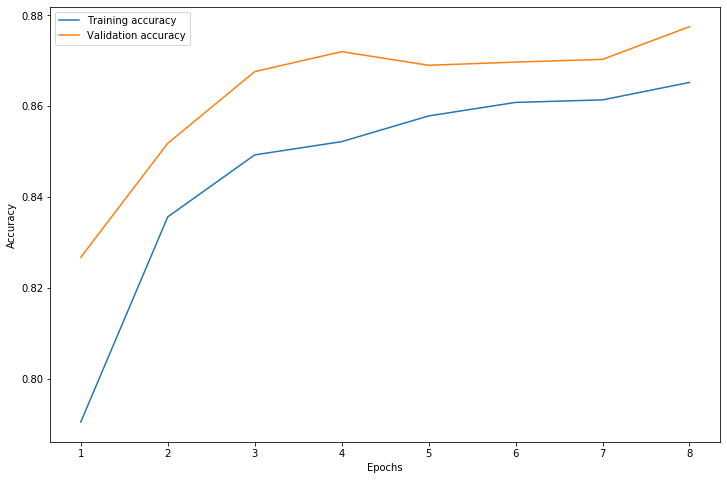

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.title('Modelo de base')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

## `ReduceLROnPlateau`

Este *callback* se va a encargar de reducir la *learning rate* del modelo cuando una determinada métrica a monitorear deje de mejorar. Muchas veces, cuando los modelos se estancan en mesetas de aprendizaje, podemos introducir mejoras al aplicar reducciones de la tasa de aprendizaje en un factor de 2 a 10, que pueden ayudarnos a solventar el estancamiento.

Los argumentos de `ReduceLROnPlateau` son:

- `monitor`: la métrica que queremos monitorear durante el aprendizaje
- `factor`: el factor por el cual la *learning rate* se reduce (new_lr = lr * factor)
- `patience`: número de *epochs* que esperamos una mejora en la métrica monitoreada (si transcurren más *epochs* que esta cantidad definida sin mejoras, el entrenamiento se interrumpe)
- `verbose`: regula la verbosidad del *callback*
- `mode`: puede ser alguno de `{auto, min, max}`, esto es, si se quiere minimizar o maximizar el valor de `monitor` (`auto` infiere este comportamiento por sí mismo)
- `min_delta`: umbral para medir el nuevo óptimo, para hacer foco únicamente en cambios significativos
- `cooldown`: número de *epochs* a esperar antes de resumir las operaciones normales luego de que se redujo la *learning rate*
- `min_lr`: límite inferior para la *learning rate*

In [16]:
# Importamos la clase ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Instanciamos nuestro objeto reduce_lr y definimos una lista de callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Podemos incorporar este callback al listado anterior y trabajar con ambos a la vez
callbacks_list.append(reduce_lr)

In [17]:
# Definimos el modelo
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compilamos el modelo
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Entrenamos
history = model.fit(x_train, y_train, validation_split=10000/x_train.shape[0],
                    batch_size=32, epochs=20,
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 258us/sample - loss: 0.5958 - accuracy: 0.7907 - val_loss: 0.4849 - val_accuracy: 0.8325
Epoch 2/20
50000/50000 [==============================] - 14s 284us/sample - loss: 0.4768 - accuracy: 0.8361 - val_loss: 0.4295 - val_accuracy: 0.8527
Epoch 3/20
50000/50000 [==============================] - 13s 260us/sample - loss: 0.4574 - accuracy: 0.8460 - val_loss: 0.4061 - val_accuracy: 0.8641
Epoch 4/20
50000/50000 [==============================] - 13s 264us/sample - loss: 0.4515 - accuracy: 0.8539 - val_loss: 0.4568 - val_accuracy: 0.8601
Epoch 5/20
49984/50000 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.8575
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50000/50000 [==============================] - 13s 256us/sample - loss: 0.4481 - accuracy: 0.8574 - val_loss: 0.4231 - val_accuracy: 0.8676
Epoch 6/20
50000/50000 [=

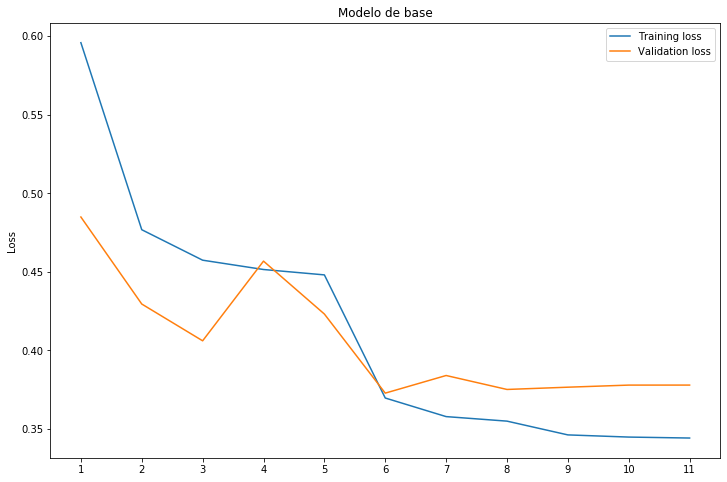

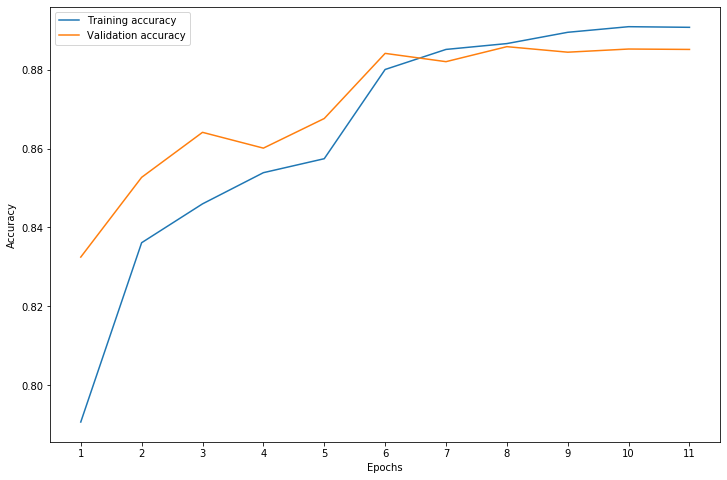

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.title('Modelo de base')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

## `ModelCheckpoint`

Guarda el modelo después de una cierta cantidad de *epochs*.

Los argumentos son:

- `filepath`: es un string con el path del archivo en que se guardará el modelo. Puede contener opciones de formato, por ejemplo, si el `filepath` es `'weights.{epoch:02d}-{val_loss:.2f}.hdf5'`, entonces los checkpoints del modelo  serán guardados con el número de *epoch* y el valor de la pérdida de validación en el nombre del archivo
- `monitor`: la métrica queremos monitorear durante el aprendizaje
- `verbose`: regula la verbosidad del *callback*
- `save_best_only`: si se setea a `True`, entonces sólo se guardará un modelo que represente una mejora con respecto al último mejor modelo según la cantidad de `monitor`
- `save_weights_only`: si se setea a `True`, entonces sólo los pesos del modelo serán guardados, y no su arquitectura completa
- `mode`: puede ser alguno de `{auto, min, max}`, esto es, si se quiere minimizar o maximizar el valor de `monitor` (`auto` infiere este comportamiento por sí mismo)
- `save_freq`: intervalo (número de *epochs*) entre checkpoints

In [20]:
# Importamos la clase ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Instanciamos nuestro objeto chekpoint y definimos una lista de callbacks
checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')

# Podemos incorporar este callback al listado anterior y trabajar con todos a la vez
callbacks_list.append(checkpoint)

In [21]:
# Definimos el modelo
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compilamos el modelo
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Entrenamos
history = model.fit(x_train, y_train, validation_split=10000/x_train.shape[0],
                    batch_size=32, epochs=20,
                    callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 243us/sample - loss: 0.5937 - accuracy: 0.7923 - val_loss: 0.4462 - val_accuracy: 0.8424
Epoch 2/20
50000/50000 [==============================] - 12s 246us/sample - loss: 0.4777 - accuracy: 0.8370 - val_loss: 0.4618 - val_accuracy: 0.8348
Epoch 3/20
50000/50000 [==============================] - 13s 265us/sample - loss: 0.4605 - accuracy: 0.8469 - val_loss: 0.4439 - val_accuracy: 0.8527
Epoch 4/20
50000/50000 [==============================] - 13s 256us/sample - loss: 0.4514 - accuracy: 0.8542 - val_loss: 0.4233 - val_accuracy: 0.8698
Epoch 5/20
50000/50000 [==============================] - 11s 220us/sample - loss: 0.4495 - accuracy: 0.8575 - val_loss: 0.4403 - val_accuracy: 0.8700
Epoch 6/20
49920/50000 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8600
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50000/50000 [=

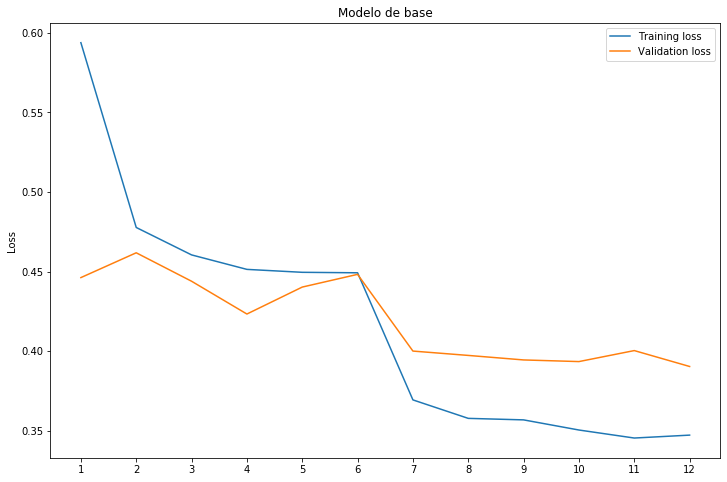

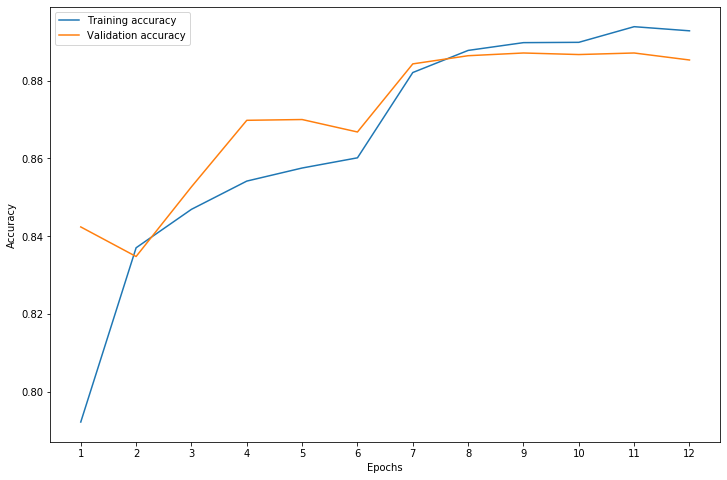

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.title('Modelo de base')
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xticks(ticks=epochs)
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])

plt.figure(figsize=(12,8))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xticks(ticks=list(epochs))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy']);

In [24]:
test_loss, test_acc = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 76us/sample - loss: 0.4335 - accuracy: 0.8764


## Conclusiones

Hemos visto qué son los *callbacks* y  cómo se implementan en Keras para supervisar el proceso de entrenamiento y tomar medidas en función del estado del modelo. Algunos de los *callbacks* que se pueden utilizar son:

- `EarlyStopping`, interrumpe el aprendizaje de manera temprana si comienza a detectarse *overfitting*
- `ReduceLROnPlateau`, se encarga de reducir la *learning rate* cuando una determinada métrica de monitoreo deja de mejorar
- `ModelCheckpoint`, nos permite ir guardando en disco los valores de los parámetros aprendidos por la red *epoch* tras *epoch*

Vimos que los *callbacks* se instancian a partir de clases que debemos importar del módulo de `callbacks` de Keras y que debemos incluirlos en una lista que luego ingresa en la llamada al método `fit()` con el argumento `callbacks`, donde perfectamente podemos conjugar varios de ellos en simultáneo.

El listado completo de *callbacks* disponible puede consultarse [aquí](https://keras.io/callbacks/).